# RP55 analysis and 2D graphics


The objective of this example is to present problem 55 of the BBRC. We also present graphic elements for the visualization of the limit state surface in 2 dimensions.

The dimension is equal to 2 and the probability is close to $10^{-2}$. This makes this problem relatively easy to solve. The distribution is uniform in the square $[-1,1]^2$. The failure domain is made of 5 diagonal bands. Capturing these bands is relatively easy and a Monte-Carlo simulation perform well in this case. The FORM method cannot perform correctly, since the failure domain cannot be linearized in the gaussian space. Hence, the SORM or FORM-IS methods do not perform satisfactorily.

In [1]:
import openturns as ot
import numpy as np
import otbenchmark as otb
from shapely.geometry import Polygon

In [2]:
problem = otb.ReliabilityProblem55()

In [3]:
print(problem)

name = RP55
event = class=ThresholdEventImplementation antecedent=class=CompositeRandomVector function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x1,x2,gsys] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,x2] outputVariablesNames=[gsys] formulas=[var g1 := 0.2 + 0.6 * (x1 - x2)^4 - (x1 - x2) / sqrt(2);var g2 := 0.2 + 0.6 * (x1 - x2)^4 + (x1 - x2) / sqrt(2);var g3 := (x1 - x2) + 5 / sqrt(2) - 2.2;var g4 := (x2 - x1) + 5 / sqrt(2) - 2.2;gsys := min(g1, g2, g3, g4)] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,x2] outputVariablesNames=[gsys] formulas=[var g1 := 0.2 + 0.6 * (x1 - x2)^4 - (x1 - x2) / sqrt(2);var g2 := 0.2 + 0.6 * (x1 - x2)^4 + (x1 - x2) / sqrt(2);var g3 := (x1 - x2) + 5 / sqrt(2) - 2.2;var g4 := (x2 - x1) + 5 / sqrt(2) - 2.2;gsys := min(g1, g2, g3, g4)] hessianImplementation=class=SymbolicHessia

In [4]:
event = problem.getEvent()
g = event.getFunction()

In [5]:
problem.getProbability()

0.5600144282863704

## Compute the bounds of the domain

In [6]:
inputVector = event.getAntecedent()
distribution = inputVector.getDistribution()
X1 = distribution.getMarginal(0)
X2 = distribution.getMarginal(1)
alphaMin = 0.00001
alphaMax = 1 - alphaMin
lowerBound = ot.Point(
    [X1.computeQuantile(alphaMin)[0], X2.computeQuantile(alphaMin)[0]]
)
upperBound = ot.Point(
    [X1.computeQuantile(alphaMax)[0], X2.computeQuantile(alphaMax)[0]]
)

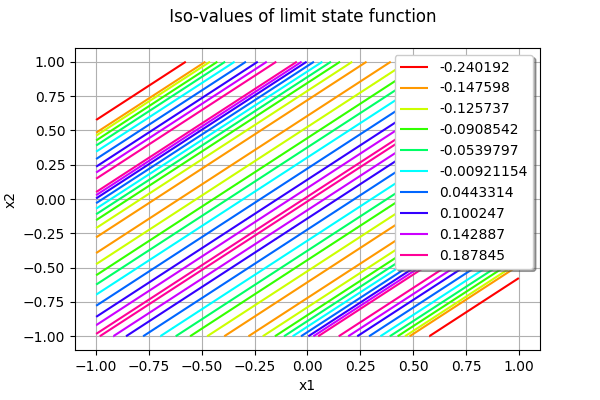

In [7]:
nbPoints = [100, 100]
figure = g.draw(lowerBound, upperBound, nbPoints)
figure.setTitle(" Iso-values of limit state function")
figure

## Print the iso-values of the distribution

/home/osboxes/Documents/venvbbrc/lib/python3.7/site-packages/matplotlib/contour.py:1226: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


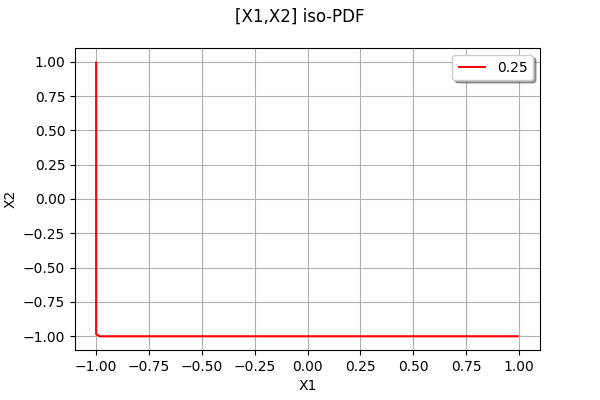

In [8]:
distribution.drawPDF()

In [9]:
sampleSize = 5000
sampleInput = inputVector.getSample(sampleSize)
sampleOutput = g(sampleInput)
drawEvent = otb.DrawEvent(event)

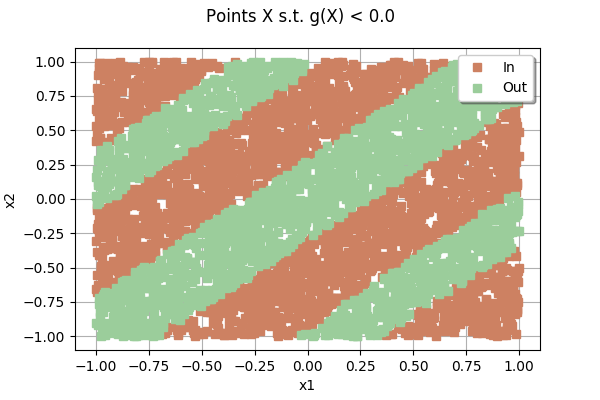

In [10]:
cloud = drawEvent.drawSampleCrossCut(sampleSize)
cloud

## Draw the limit state surface

In [11]:
bounds = ot.Interval(lowerBound, upperBound)
bounds

class=Interval name=Unnamed dimension=2 lower bound=class=Point name=Unnamed dimension=2 values=[-0.99998,-0.99998] upper bound=class=Point name=Unnamed dimension=2 values=[0.99998,0.99998] finite lower bound=[1,1] finite upper bound=[1,1]

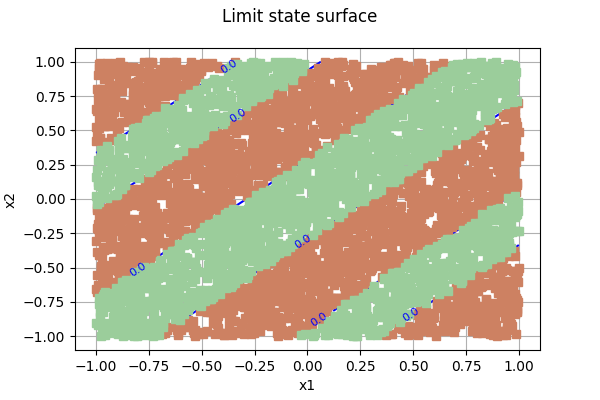

In [12]:
graph = drawEvent.drawLimitStateCrossCut(bounds)
graph.add(cloud)
graph

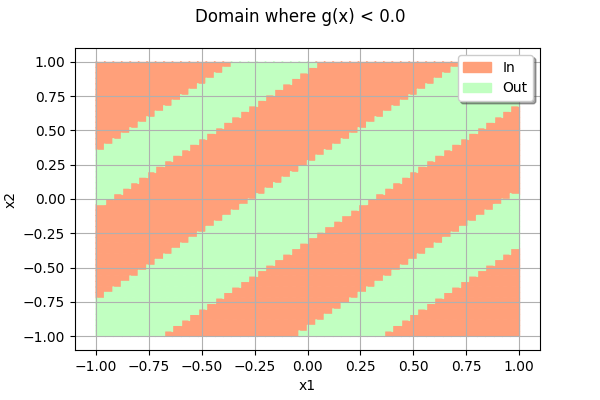

In [13]:
domain = drawEvent.fillEventCrossCut(bounds)
domain

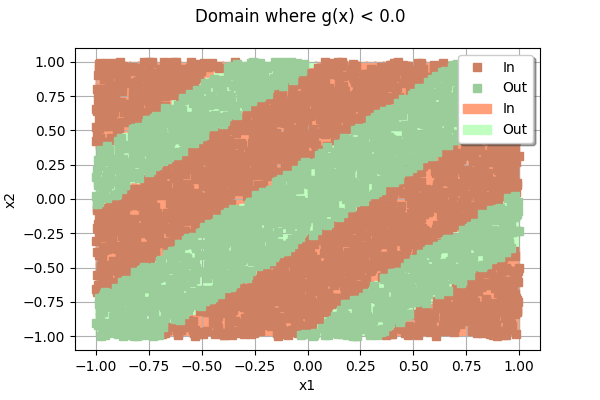

In [14]:
domain.add(cloud)
domain

## Perform Monte-Carlo simulation

In [15]:
algoProb = ot.ProbabilitySimulationAlgorithm(event)
algoProb.setMaximumOuterSampling(1000)
algoProb.setMaximumCoefficientOfVariation(0.01)
algoProb.run()

In [16]:
resultAlgo = algoProb.getResult()
neval = g.getEvaluationCallsNumber()
print("Number of function calls = %d" % (neval))
pf = resultAlgo.getProbabilityEstimate()
print("Failure Probability = %.4f" % (pf))
level = 0.95
c95 = resultAlgo.getConfidenceLength(level)
pmin = pf - 0.5 * c95
pmax = pf + 0.5 * c95
print("%.1f %% confidence interval :[%.4f,%.4f] " % (level * 100, pmin, pmax))

Number of function calls = 43704
Failure Probability = 0.5600
95.0 % confidence interval :[0.5292,0.5908] 


## With FORM-IS

In [17]:
maximumEvaluationNumber = 1000
maximumAbsoluteError = 1.0e-3
maximumRelativeError = 1.0e-3
maximumResidualError = 1.0e-3
maximumConstraintError = 1.0e-3
nearestPointAlgorithm = ot.AbdoRackwitz()
nearestPointAlgorithm.setMaximumCallsNumber(maximumEvaluationNumber)
nearestPointAlgorithm.setMaximumAbsoluteError(maximumAbsoluteError)
nearestPointAlgorithm.setMaximumRelativeError(maximumRelativeError)
nearestPointAlgorithm.setMaximumResidualError(maximumResidualError)
nearestPointAlgorithm.setMaximumConstraintError(maximumConstraintError)

In [18]:
metaAlgorithm = otb.ReliabilityBenchmarkMetaAlgorithm(problem)
benchmarkResult = metaAlgorithm.runFORMImportanceSampling(
    nearestPointAlgorithm, maximumOuterSampling=10 ** 5, coefficientOfVariation=0.0
)

In [19]:
print(benchmarkResult.summary())

computedProbability = 0.5609716261066401
exactProbability = 0.5600144282863704
absoluteError = 0.0009571978202697062
numberOfCorrectDigits = 2.7671975154038626
numberOfFunctionEvaluations = 101007
numberOfDigitsPerEvaluation = 2.7396096462659644e-05


## With Quasi-Monte-Carlo

In [20]:
sequence = ot.SobolSequence()
experiment = ot.LowDiscrepancyExperiment(sequence, 1)
experiment.setRandomize(False)

In [21]:
algo = ot.ProbabilitySimulationAlgorithm(event, experiment)
algo.setMaximumOuterSampling(10 ** 3)
algo.setMaximumCoefficientOfVariation(0.0)
algo.setBlockSize(10 ** 3)
algo.run()

In [22]:
result = algo.getResult()
probability = result.getProbabilityEstimate()
print("Pf=", probability)

Pf= 0.5593869999999994
